In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from datetime import date, timedelta

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
%matplotlib inline

In [2]:
path = './input/'
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
transactions = pd.read_csv(path+"transactions.csv")
items = pd.read_csv(path+"items.csv")
stores = pd.read_csv(path+"stores.csv")
oil = pd.read_csv(path+"oil.csv")
holidays_events = pd.read_csv(path+"holidays_events.csv")

/Users/wanghe142/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 数据初探

### train

In [5]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


In [9]:
train.describe()

,id,store_nbr,item_nbr,unit_sales
count,1.254970e+08,1.254970e+08,1.254970e+08,1.254970e+08
mean,6.274852e+07,2.746458e+01,9.727692e+05,8.554865e+00
std,3.622788e+07,1.633051e+01,5.205336e+05,2.360515e+01
min,0.000000e+00,1.000000e+00,9.699500e+04,-1.537200e+04
25%,3.137426e+07,1.200000e+01,5.223830e+05,2.000000e+00
50%,6.274852e+07,2.800000e+01,9.595000e+05,4.000000e+00
75%,9.412278e+07,4.300000e+01,1.354380e+06,9.000000e+00
max,1.254970e+08,5.400000e+01,2.127114e+06,8.944000e+04


In [13]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), round(train[col].isnull().sum() * 100 / train.shape[0], 3), round(train[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
5,onpromotion,2,17.257,76.519,object
0,id,125497040,0.000,0.000,int64
1,date,1684,0.000,0.094,object
2,store_nbr,54,0.000,2.799,int64
3,item_nbr,4036,0.000,0.067,int64
4,unit_sales,258474,0.000,18.682,float64


### test

In [7]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           int64 
 1   date         object
 2   store_nbr    int64 
 3   item_nbr     int64 
 4   onpromotion  bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 106.1+ MB


In [10]:
test.describe()

,id,store_nbr,item_nbr
count,3.370464e+06,3.370464e+06,3.370464e+06
mean,1.271823e+08,2.750000e+01,1.244798e+06
std,9.729693e+05,1.558579e+01,5.898362e+05
min,1.254970e+08,1.000000e+00,9.699500e+04
25%,1.263397e+08,1.400000e+01,8.053210e+05
50%,1.271823e+08,2.750000e+01,1.294665e+06
75%,1.280249e+08,4.100000e+01,1.730015e+06
max,1.288675e+08,5.400000e+01,2.134244e+06


In [14]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), round(test[col].isnull().sum() * 100 / test.shape[0], 3), round(test[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
0,id,3370464,0.0,0.000,int64
1,date,16,0.0,6.250,object
2,store_nbr,54,0.0,1.852,int64
3,item_nbr,3901,0.0,0.026,int64
4,onpromotion,2,0.0,94.108,bool


### transactions

In [15]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [16]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [17]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [18]:
stats = []
for col in transactions.columns:
    stats.append((col, transactions[col].nunique(), round(transactions[col].isnull().sum() * 100 / transactions.shape[0], 3), round(transactions[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), transactions[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
0,date,1682,0.0,0.065,object
1,store_nbr,54,0.0,2.010,int64
2,transactions,4993,0.0,0.108,int64


### items

In [19]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [20]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [21]:
items.describe()

,item_nbr,class,perishable
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,0.240488
std,5.876872e+05,1484.9109,0.427432
min,9.699500e+04,1002.0000,0.000000
25%,8.181108e+05,1068.0000,0.000000
50%,1.306198e+06,2004.0000,0.000000
75%,1.904918e+06,2990.5000,0.000000
max,2.134244e+06,7780.0000,1.000000


In [22]:
stats = []
for col in items.columns:
    stats.append((col, items[col].nunique(), round(items[col].isnull().sum() * 100 / items.shape[0], 3), round(items[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), items[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
0,item_nbr,4100,0.0,0.024,int64
1,family,33,0.0,32.537,object
2,class,337,0.0,3.244,int64
3,perishable,2,0.0,75.951,int64


### stores

In [23]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [24]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [25]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [26]:
stats = []
for col in stores.columns:
    stats.append((col, stores[col].nunique(), round(stores[col].isnull().sum() * 100 / stores.shape[0], 3), round(stores[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), stores[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
0,store_nbr,54,0.0,1.852,int64
1,city,22,0.0,33.333,object
2,state,16,0.0,35.185,object
3,type,5,0.0,33.333,object
4,cluster,17,0.0,12.963,int64


### oil

In [32]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [28]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [29]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


### holidays_events

In [30]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [31]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [33]:
stats = []
for col in holidays_events.columns:
    stats.append((col, holidays_events[col].nunique(), round(holidays_events[col].isnull().sum() * 100 / holidays_events.shape[0], 3), round(holidays_events[col].value_counts(normalize=True, dropna=False).values[0] * 100,3), holidays_events[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['特征', '属性个数', '缺失值占比', '最大属性占比', '特征类型'])
stats_df.sort_values('缺失值占比', ascending=False)[:10]

,特征,属性个数,缺失值占比,最大属性占比,特征类型
0,date,312,0.0,1.143,object
1,type,6,0.0,63.143,object
2,locale,3,0.0,49.714,object
3,locale_name,24,0.0,49.714,object
4,description,103,0.0,2.857,object
5,transferred,2,0.0,96.571,bool


In [34]:
holidays_events['locale'].value_counts()

National    174
Local       152
Regional     24
Name: locale, dtype: int64

## 单变量分析

In [3]:
train["date"] =  pd.to_datetime(train["date"])
# train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month

In [37]:
train['item_nbr'].value_counts()

502331     83475
314384     83450
364606     83308
265559     83047
559870     82513
           ...  
2123463        5
2123747        3
2122818        2
2015898        1
2011451        1
Name: item_nbr, Length: 4036, dtype: int64

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newa

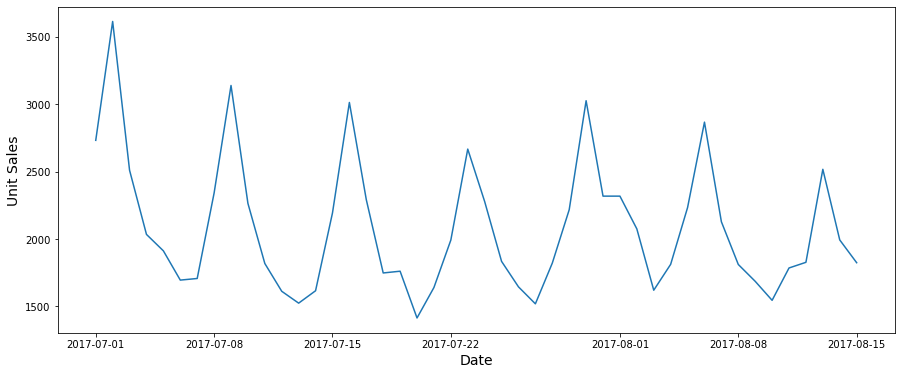

In [38]:
plt.figure(figsize=(15,6))

# 绘制总计 unit sales
df_plot = train[train.date>=pd.datetime(2017,7,1)][train.item_nbr==502331].groupby(by=['date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.date, df_plot.unit_sales)

# 设置 x 和 y 轴
plt.xlabel('Date',fontsize=14)
plt.ylabel('Unit Sales',fontsize=14)

plt.savefig("12_date_sale_feature.svg", format="svg")

In [ ]:
fig, ax = plt.subplots(1)
fig.autofmt_xdate()
fig.set_figheight(10)
fig.set_figwidth(16)

# 绘制总计 unit sales
df_plot = train.groupby(by=['date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.date, df_plot.unit_sales)

# 绘制有促销的 unit sales
df_plot = train.loc[train['onpromotion'] == True].groupby(by=['date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.date, df_plot.unit_sales)

# 绘制没有促销的 unit sales
df_plot = train.loc[train['onpromotion'] == False].groupby(by=['date']).agg({'unit_sales':'sum'}).reset_index()
plt.plot(df_plot.date, df_plot.unit_sales)

# 设置legend
plt.legend(['Total unit sales','On Promotion','Not On Promotion'], fontsize=14)

# 设置 x 和 y 轴
plt.xlabel('Date',fontsize=14)
plt.ylabel('Unit Sales',fontsize=14)

plt.savefig("12_date_sale.svg", format="svg")

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(data=train, x='store_nbr')
plt.xticks(rotation=75, fontsize=12)
plt.savefig("12_store_nbr.svg", format="svg")

In [56]:
df_plot

,item_nbr_index,item_nbr,count
0,0,96995,5229
1,1,99197,4902
2,2,103501,35841
3,3,103520,53175
4,4,103665,50449
...,...,...,...
4031,4031,2123863,12
4032,4032,2124052,704
4033,4033,2126842,12
4034,4034,2126944,5


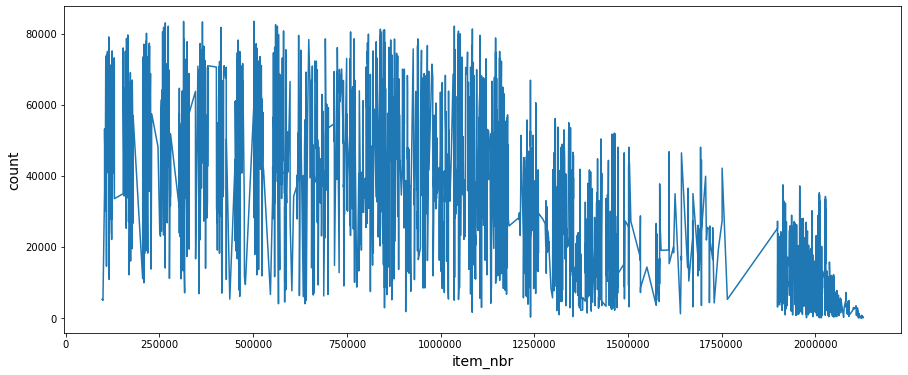

In [4]:
plt.figure(figsize=(15,6))

df_plot = train.groupby(by=['item_nbr']).agg({'id':'count'}).reset_index()
df_plot.columns = ['item_nbr', 'count']
plt.plot(df_plot['item_nbr'], df_plot['count'])

plt.xlabel('item_nbr',fontsize=14)
plt.ylabel('count',fontsize=14)
plt.savefig("12_item_nbr.svg", format="svg")

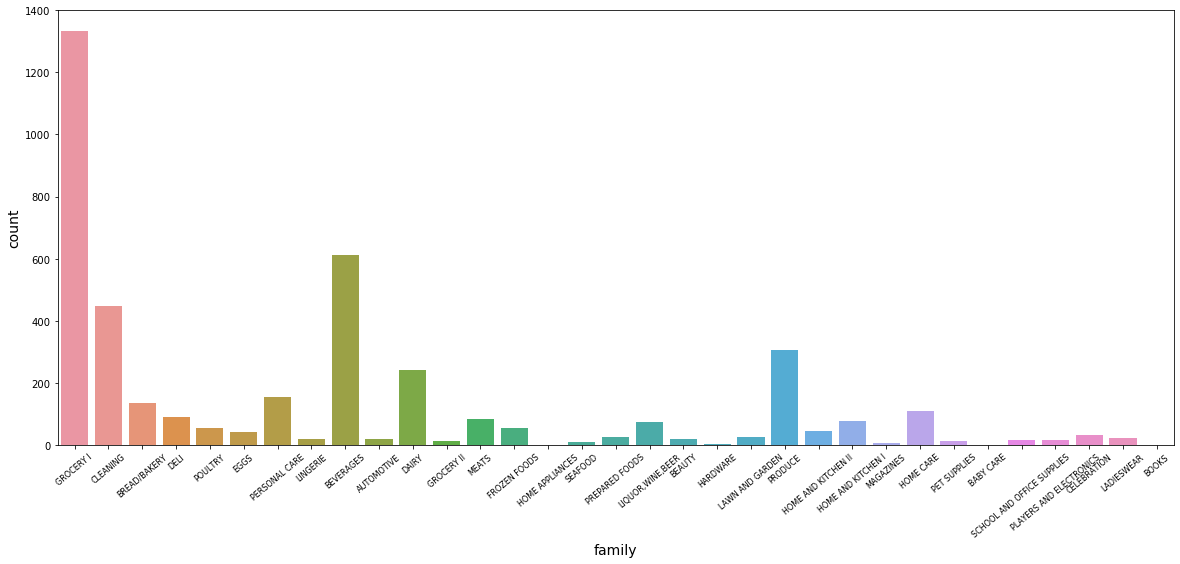

In [18]:
plt.figure(figsize=(20,8))
sns.countplot(data=items, x='family')
plt.xticks(rotation=40, fontsize=8)
plt.xlabel('family',fontsize=14)
plt.ylabel('count',fontsize=14)
plt.savefig("12_items_family.svg", format="svg")

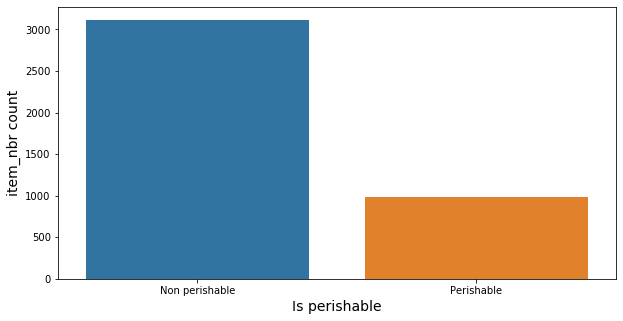

In [65]:
df_plot = items.fillna(-1).groupby(by=['perishable']).agg({'item_nbr':'count'}).reset_index()

df_plot.perishable = df_plot.perishable.replace({0:'Non perishable', 1:'Perishable', -1: 'Missing'})

plt.figure(figsize=(10,5))

sns.barplot(data=df_plot, x='perishable', y='item_nbr')

plt.xlabel('Is perishable', fontsize=14)
plt.ylabel('item_nbr count', fontsize=14)
plt.savefig("12_items_perishable.svg", format="svg")

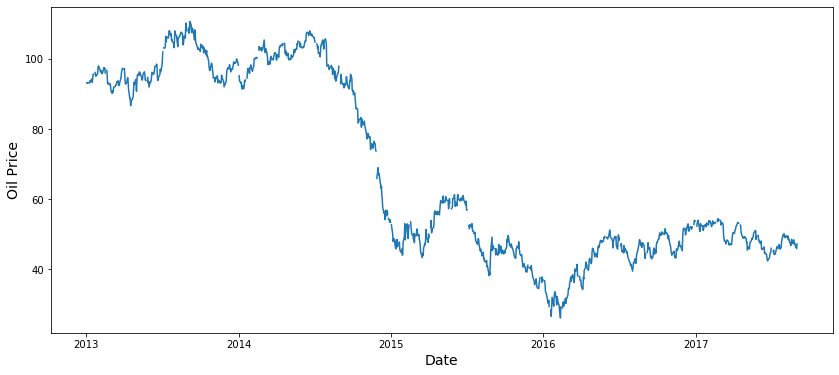

In [5]:
oil["date"] =  pd.to_datetime(oil["date"])

plt.figure(figsize=(14,6))
plt.plot(oil.date, oil.dcoilwtico)

plt.xlabel('Date',fontsize=14)
plt.ylabel('Oil Price',fontsize=14)
plt.savefig("12_oil_dcoilwtico.svg", format="svg")

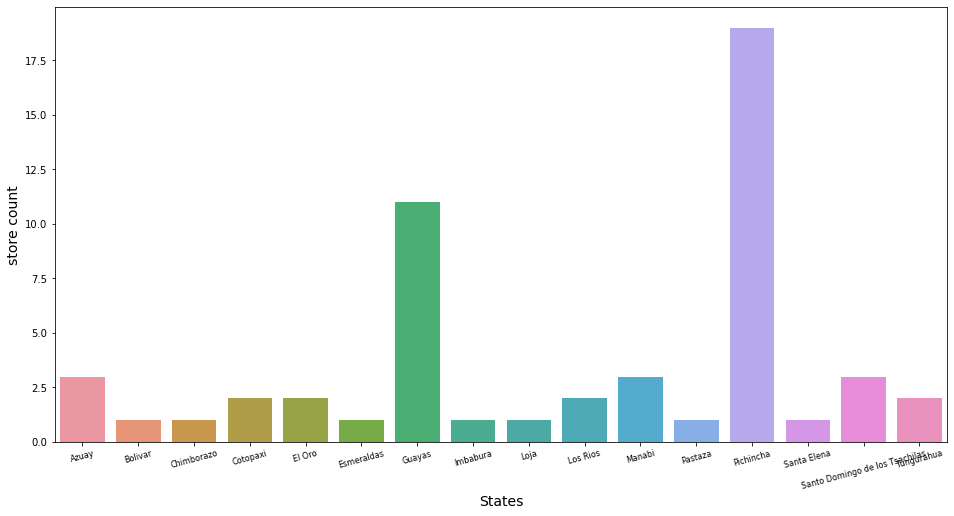

In [37]:
df_plot = stores.groupby('state').agg({'store_nbr':'count'}).reset_index()

plt.figure(figsize=(16,8))
sns.barplot(data=df_plot, x='state',y='store_nbr')

plt.xlabel('States',fontsize=14)
plt.ylabel('store count', fontsize=14)
plt.xticks(rotation=15, fontsize=8)
plt.savefig("12_stores_state.svg", format="svg")

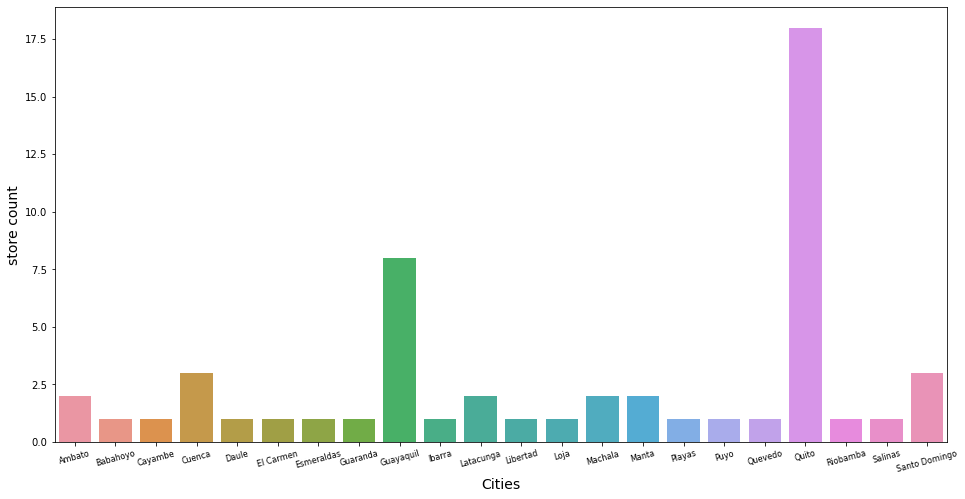

In [40]:
df_plot = stores.groupby('city').agg({'store_nbr':'count'}).reset_index()

plt.figure(figsize=(16,8))

sns.barplot(data=df_plot, x='city',y='store_nbr')

plt.xlabel('Cities',fontsize=14)
plt.ylabel('store count', fontsize=14)

plt.xticks(rotation=15, fontsize=8)
plt.savefig("12_stores_city.svg", format="svg")

## 多变量分析

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

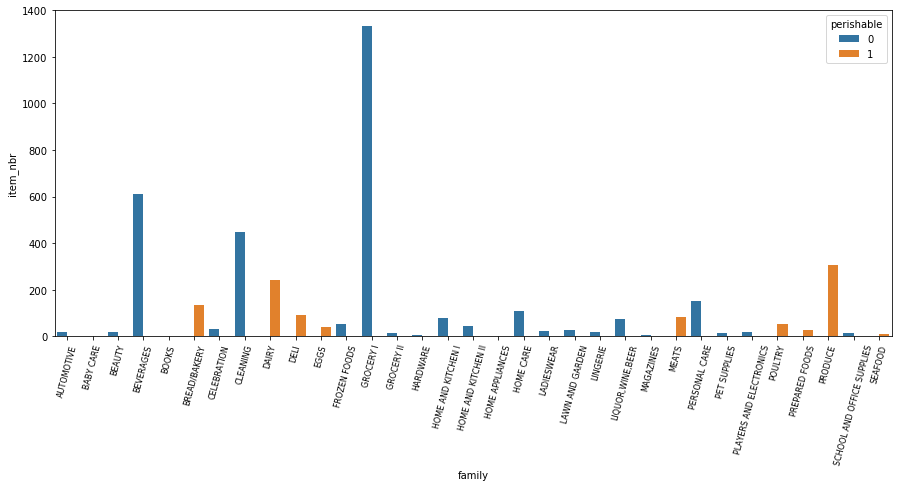

In [38]:
df_plot = items.groupby(['family','perishable']).agg({'item_nbr':'count'}).reset_index()
plt.figure(figsize=(15,6))
sns.barplot(data=df_plot, y='item_nbr', x='family', hue='perishable')
plt.xticks(rotation=75, fontsize=8)

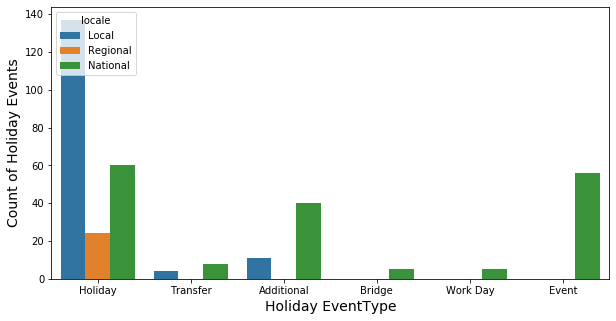

In [29]:
plt.figure(figsize=(10,5))

sns.countplot(data=holidays_events, x='type', hue='locale')

plt.xlabel('Holiday EventType', fontsize=14)
plt.ylabel('Count of Holiday Events', fontsize=14)
plt.savefig("12_holidays_events.svg", format="svg")

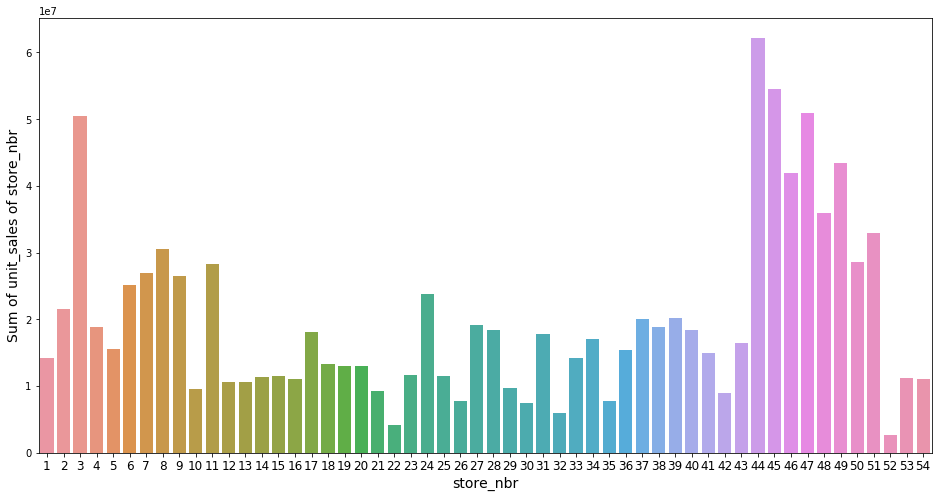

In [11]:
df_plot = train.groupby('store_nbr').agg({'unit_sales':'sum'}).reset_index()

plt.figure(figsize=(16,8))
sns.barplot(data=df_plot, x='store_nbr',y='unit_sales')

plt.xlabel('store_nbr',fontsize=14)
plt.ylabel('Sum of unit_sales of store_nbr', fontsize=14)
plt.xticks(fontsize=12)
plt.savefig("12_store_label.svg", format="svg")

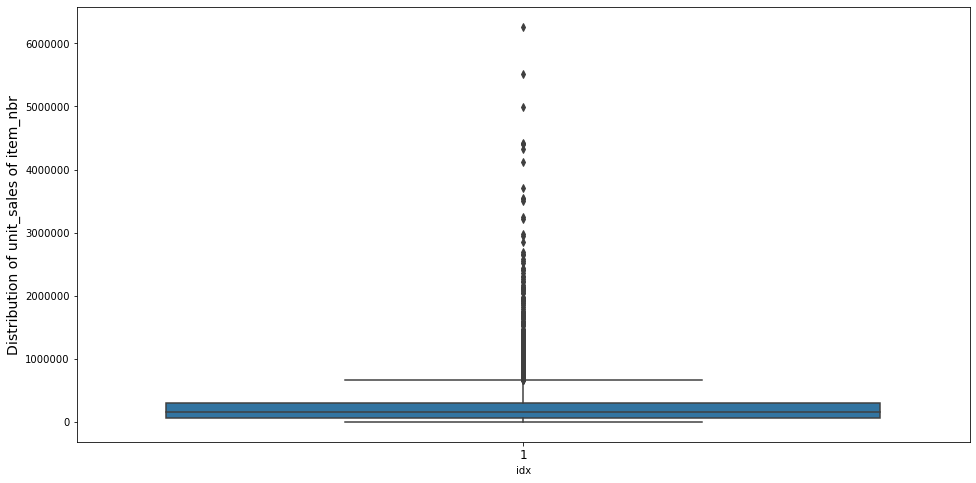

In [21]:
df_plot = train.groupby('item_nbr').agg({'unit_sales':'sum'}).reset_index()
df_plot['idx'] = 1
plt.figure(figsize=(16,8))
sns.boxplot(data=df_plot, x='idx',y='unit_sales')

plt.ylabel('Distribution of unit_sales of item_nbr', fontsize=14)
plt.xticks(fontsize=12)
plt.savefig("12_item_label.svg", format="svg")

In [15]:
train = pd.merge(train, items, on='item_nbr', how='left')

In [16]:
df_plot = train.groupby(by=['date','perishable']).agg({'unit_sales':'sum'}).reset_index()
df_plot["date"] =  pd.to_datetime(df_plot["date"])

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, N

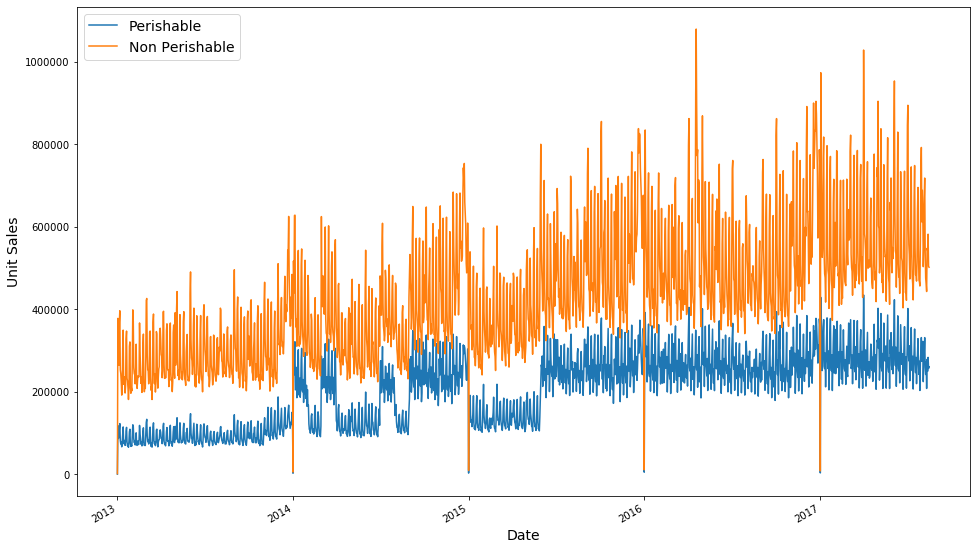

In [18]:
fig, ax = plt.subplots(1)
fig.autofmt_xdate()
fig.set_figheight(10)
fig.set_figwidth(16)


plt.plot(df_plot.loc[df_plot['perishable'] == True,'date'], df_plot.loc[df_plot['perishable'] == True,'unit_sales'])

plt.plot(df_plot.loc[df_plot['perishable'] == False,'date'], df_plot.loc[df_plot['perishable'] == False,'unit_sales'])

# 设置legend
plt.legend(['Perishable','Non Perishable'], fontsize=14)

# 设置 x 和 y 轴
plt.xlabel('Date',fontsize=14)
plt.ylabel('Unit Sales',fontsize=14)

plt.savefig("12_perishable_date_label.svg", format="svg")

In [20]:
train['perishable'].value_counts()

0    93794504
1    31702536
Name: perishable, dtype: int64

In [6]:
df_train

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True
